In [1]:
import numpy as np
from joblib import Parallel, delayed

## Datasets

| Datasets        | #images           | #labels  | #images per label (minimum)|
| --------------- |:-----------------:| :-------:|---------------------------:|
| fgvc-aircraft-2013b | 10000 | 100 | 100 |
| birdSnap    | 49829 | 500 | 69 (100 for most species)  |

To avoid unbalanced number of labels per task, we use only a small proportion (100*100 samples) of BirdSnaps.

In [2]:
n_task_aircraft = 5 # divide aircraft into 5 tasks
n_task_birdsnap = 5 # for birdsnap, select 100 species that contains 100 samples and divide these 100 into 5 tasks 
n_task = 10

n_label_per_task = 20
n_sample_label = 90 # limited by birdsnap
test_size=0.4 # 54 train, 36 test

In [3]:
path_aircraft_x_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/aircraft_x_all.npy'
path_aircraft_y_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/aircraft_y_all.npy'

path_birdsnap_x_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/birdsnap_x_all.npy'
path_birdsnap_y_all = 'F:/Programming/Python/NDD/Dataset_Preprocessing/data/birdsnap_y_all.npy'

In [4]:
from numpy import load

aircraft_x_all = np.load(path_aircraft_x_all)
aircraft_y_all = np.load(path_aircraft_y_all)

birdsnap_x_all = np.load(path_birdsnap_x_all)
birdsnap_y_all = np.load(path_birdsnap_y_all)

In [5]:
aircraft_x_all[aircraft_y_all == 1][:90].shape

(90, 32, 32, 3)

In [6]:
from sklearn.model_selection import train_test_split

train_x_task = [[], [], [], [], [], [], [], [], [], []]
test_x_task = [[], [], [], [], [], [], [], [], [], []]
train_y_task = [[], [], [], [], [], [], [], [], [], []]
test_y_task = [[], [], [], [], [], [], [], [], [], []]

# load aircraft data to tasks
for i in range(n_task_aircraft):
    X = np.empty([0,32,32,3])
    Y = np.empty([0,])
    for j in range(n_label_per_task):
        new_x = aircraft_x_all[aircraft_y_all == n_label_per_task*i + j + 1][:90]
        new_y = aircraft_y_all[aircraft_y_all == n_label_per_task*i + j + 1][:90]
        X = np.concatenate((X, new_x), axis=0)
        Y = np.concatenate((Y, new_y), axis=0)
    train_x_task[i], test_x_task[i], train_y_task[i], test_y_task[i] = train_test_split(X, Y,test_size=test_size)
    

In [7]:
train_x_task[0].shape

(1080, 32, 32, 3)

In [8]:
# load birdsnap data to tasks
for i in range(n_task_birdsnap):
    X = np.empty([0,32,32,3])
    Y = np.empty([0,])
    for j in range(n_label_per_task):
        new_x = birdsnap_x_all[birdsnap_y_all == n_label_per_task*i + j + 1][:90]
        new_y = birdsnap_y_all[birdsnap_y_all == n_label_per_task*i + j + 1][:90] + 100 #should add 100 to distinguish between birdsnap and aircraft?
        X = np.concatenate((X, new_x), axis=0)
        Y = np.concatenate((Y, new_y), axis=0)
    train_x_task[n_task_aircraft+i], test_x_task[n_task_aircraft+i], train_y_task[n_task_aircraft+i], test_y_task[n_task_aircraft+i] = train_test_split(X, Y,test_size=test_size)

In [9]:
train_y_task[9].shape

(1080,)

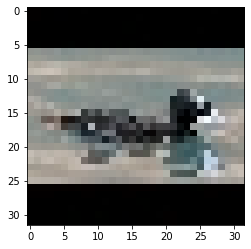

In [10]:
import matplotlib.pyplot as plt

# task 1-5 is aircraft, 6-10 is birdsnap
img = train_x_task[5][0]
plt.imshow(img.astype(np.uint8))

In [11]:
from flying_functions import single_experiment

# L2F Model

model = 'uf'
ntrees = 10     # number of trees, used when model is uf
num_repetition = 20

accuracy_list = Parallel(n_jobs=5)(delayed(single_experiment)(train_x_task,test_x_task,train_y_task,test_y_task,ntrees,model) for _ in range(num_repetition))

accuracy_all_avg_uf = np.average(accuracy_list, axis = 0)

In [13]:
accuracy_all_avg_uf

array([0.07375   , 0.09868056, 0.13680556, 0.16506944, 0.160625  ,
       0.10243056, 0.10965278, 0.09902778, 0.09895833, 0.09555556,
       0.07375   , 0.07888889, 0.10520833, 0.08152778, 0.11298611,
       0.16243056, 0.08479167, 0.12013889, 0.17034722, 0.20458333,
       0.084375  , 0.12215278, 0.17756944, 0.21173611, 0.22006944,
       0.08729167, 0.125625  , 0.18111111, 0.21534722, 0.22333333,
       0.13229167, 0.08881944, 0.12444444, 0.18479167, 0.21513889,
       0.22791667, 0.13430556, 0.12819444, 0.08909722, 0.12840278,
       0.18854167, 0.21833333, 0.23069444, 0.13861111, 0.13263889,
       0.11465278, 0.08777778, 0.13027778, 0.19263889, 0.22375   ,
       0.23395833, 0.14013889, 0.13583333, 0.11673611, 0.14576389,
       0.08916667, 0.13006944, 0.19680556, 0.22180556, 0.23479167,
       0.14333333, 0.13770833, 0.118125  , 0.14993056, 0.12631944])

In [14]:
from flying_functions import calculate_results

err_uf, bte_uf, fte_uf, te_uf = calculate_results(accuracy_all_avg_uf)

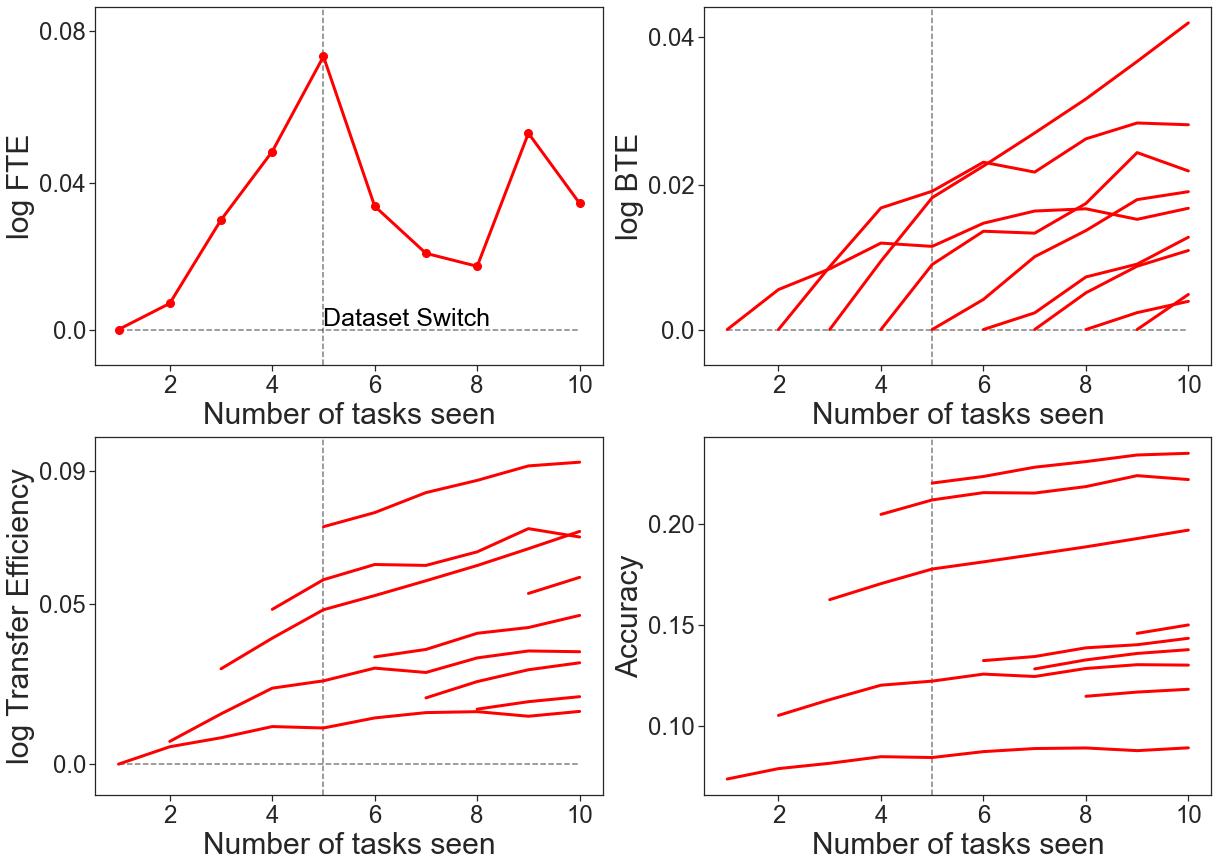

In [59]:
err = err_uf
bte = bte_uf
fte = fte_uf
te  = te_uf

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

num_tasks = 10
sns.set(style='ticks')

fontsize = 30
ticksize = 24
markersize = 16
linewidth = 3

fig, ax = plt.subplots(2, 2, figsize=(20, 14.5))

# FTE
ax[0][0].axvline(x= 5,linestyle="dashed",color='black',alpha = 0.5)
ax[0][0].text(5, 1.001, 'Dataset Switch',fontsize=25, color='black')
ax[0][0].plot(np.arange(1, num_tasks + 1), fte, c='red', marker='.', markersize=markersize, linewidth=linewidth, label = 'Odif')

ax[0][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('log FTE',fontsize=fontsize)
ax[0][0].set_yticks([1, 1.0408, 1.0833])
ax[0][0].set_ylim(0.99, 1.09)

log_lbl = np.round(
    np.log([1, 1.0408, 1.0833]),
    2
)
labels = [item.get_text() for item in ax[0][0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0][0].set_yticklabels(labels)

# BTE
ax[0][1].axvline(x= 5,linestyle="dashed",color='black',alpha = 0.5)
for i in range(num_tasks):
    et = np.asarray(bte[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth=linewidth)

ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('log BTE', fontsize=fontsize)
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)

ax[0][1].set_yticks([1, 1.0202, 1.0408])
ax[0][1].set_ylim(0.995, 1.045)

log_lbl = np.round(
    np.log([1, 1.0202, 1.0408]),
    2
)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[0][1].set_yticklabels(labels)

# TE
ax[1][0].axvline(x= 5,linestyle="dashed",color='black',alpha = 0.5)
for i in range(num_tasks):
    et = np.asarray(te[i])
    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth=linewidth)

ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('log Transfer Efficiency', fontsize=fontsize)
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1, num_tasks, colors='grey', linestyles='dashed', linewidth=0.5*linewidth)

ax[1][0].set_yticks([1, 1.0513, 1.0942])
ax[1][0].set_ylim(0.99, 1.105)

log_lbl = np.round(
    np.log([1, 1.0513, 1.0942]),
    2
)
labels = [item.get_text() for item in ax[1][0].get_yticklabels()]

for ii,_ in enumerate(labels):
    labels[ii] = str(log_lbl[ii])

ax[1][0].set_yticklabels(labels)

# Accuracy
ax[1][1].axvline(x= 5,linestyle="dashed",color='black',alpha = 0.5)
for i in range(num_tasks):
    et = 1 - np.asarray(err[i])
    ns = np.arange(i + 1, num_tasks + 1)
    if i == 0: ax[1][1].plot(ns, et, c='red', linewidth=linewidth, label = 'Odif')
    else: ax[1][1].plot(ns, et, c='red', linewidth=linewidth)

ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
ax[1][1].tick_params(labelsize=ticksize)


In [63]:
from numpy import save
np.save('history/uf_ntree10_rep20_0415.npy',accuracy_all_avg_uf)